In [3]:
import Pkg; Pkg.add("Colors")
using Images, Plots, Colors, Statistics, ImageFiltering

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %1.5 %

  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]


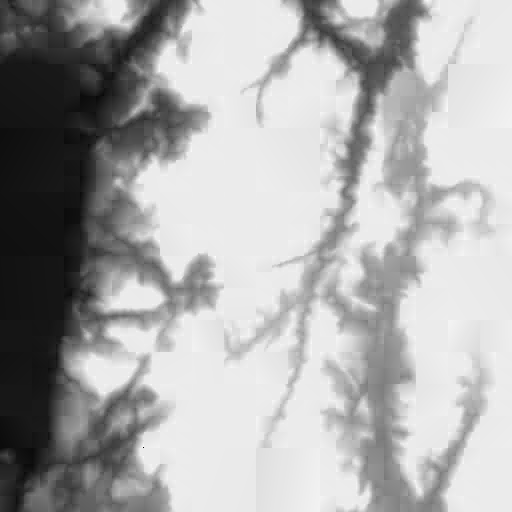

In [98]:
img = load("/home/quothbonney/gpgc/test.png")
gray = Gray.(img)

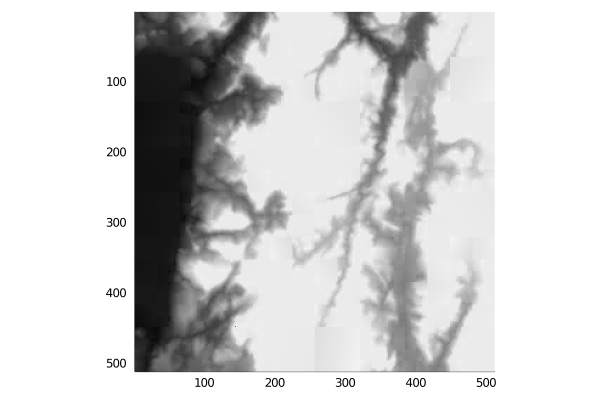

In [99]:
plot(gray)

In [100]:
K_SIZE = 5
h = 512; w=512
decon = zeros(512, 512)
for i = K_SIZE+1:h-K_SIZE
    for j = K_SIZE+1:w-K_SIZE
        arr = Float32.(gray[i-K_SIZE:5:i+K_SIZE, j-K_SIZE:5:j+K_SIZE])
        decon[i, j] = (std(arr) ^ 0.5) * 10
    end
end

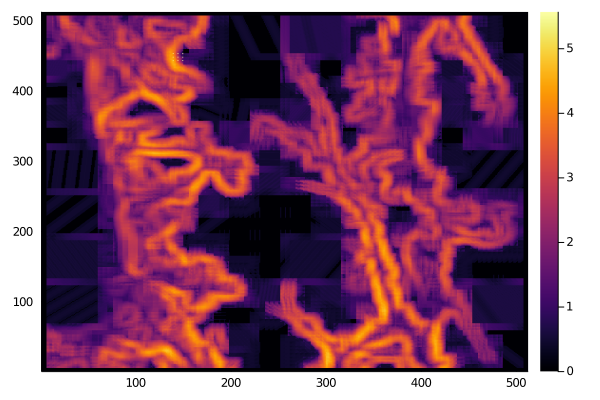

In [101]:
heatmap(decon)

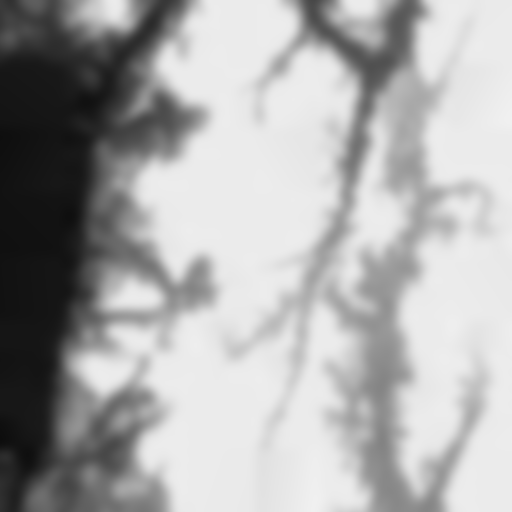

In [102]:
gauss5 = imfilter(gray, Kernel.gaussian(5))

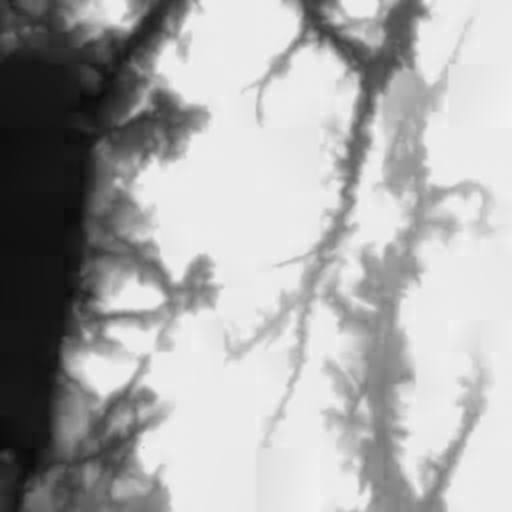

In [103]:
gauss1 = imfilter(gray, Kernel.gaussian(1))

In [104]:
arr = zeros(512, 512)

512×512 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [105]:
for i in CartesianIndices(decon)
  if decon[i] < 2
    val = decon[i] / 2
    antival = 1 - val
    z = (antival * gauss5[i]) + (val * gray[i])
    arr[i] = z
  elseif decon[i] < 4
    arr[i] = gauss1[i]
  else
    arr[i] = gray[i]
  end
end

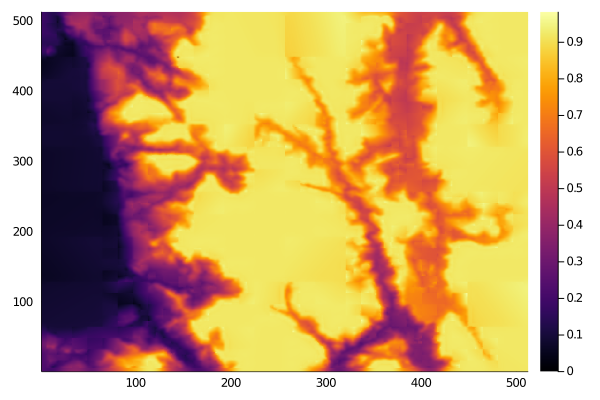

In [106]:
heatmap(arr)

In [14]:
K_SIZE = 5
h = 512; w=512
decon2 = zeros(512, 512)
for i = K_SIZE+1:h-K_SIZE
    for j = K_SIZE+1:w-K_SIZE
        arr2 = Float32.(arr[i-K_SIZE:5:i+K_SIZE, j-K_SIZE:5:j+K_SIZE])
        decon2[i, j] = (std(arr2) ^ 0.5) * 10
    end
end

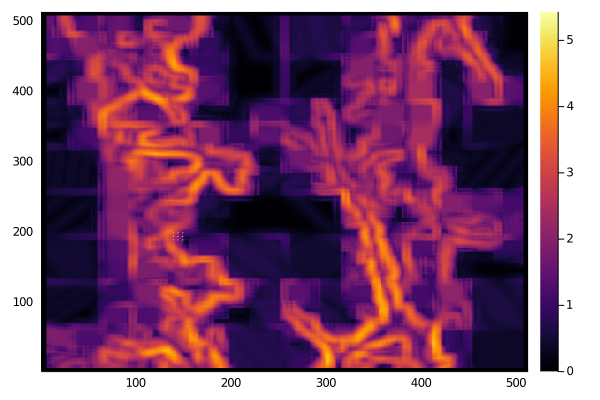

In [15]:
heatmap(decon2)

In [107]:
data = []
vectors = []
max_size = 0
filename = "../test.gpgc.log"
sz = 512
open(filename) do file
    for line in eachline(file)
        words = split(line)

        if length(words) < 4
            continue
        end
        
        global max_size
        max_size = sz
        
        size = parse(Int, words[4])
        exp = max_size / size
        
        push!(data, log2(exp))
        push!(vectors, (parse(Float64, words[1]), parse(Float64, words[2]), parse(Float64, words[3]), size))
    end
end

In [108]:
function create_offsets(sizes)
  x0 = [0.0]
  y0 = [0.0]
  b = [0.0]

  index = 1
  while index <= length(sizes)
      while b[index] < sizes[index]
          b[index] += 1
          for i in 1:3
              insert!(b, index+1, b[index])
          end

          insert!(x0, index+1, x0[index] + 1/(2^b[index]))
          insert!(x0, index+2, x0[index])
          insert!(x0, index+3, x0[index] + 1/(2^b[index]))

          insert!(y0, index+1, y0[index])
          insert!(y0, index+2, y0[index] + 1/(2^b[index]))
          insert!(y0, index+3, y0[index] + 1/(2^b[index]))
      end

      index += 1
  end

  return x0, y0
end

create_offsets (generic function with 1 method)

In [109]:
decompressed = zeros(Int, sz, sz)


x0, y0 = create_offsets(data)

println(length(x0), " ", length(y0), " ", length(vectors))
for elem in 1:length(x0)
    x_o = Int(x0[elem] * sz)
    y_o = Int(y0[elem] * sz)

    if length(vectors[elem]) < 4
        println(vectors[elem])
    end

    i, j, k, size = vectors[elem]
    for m in 0:size-1
        for n in 0:size-1
            altitude = Int(round(i*m + j*n + k))
            decompressed[y_o+m+1, x_o+n+1] = altitude
        end
    end
end


3832 3832 3832


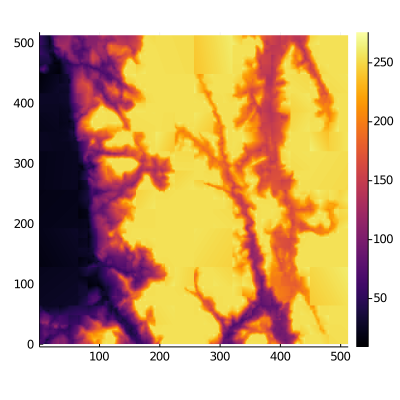

In [110]:
heatmap(decompressed, size=(400, 400), aspect_ratio=:equal)

In [111]:
nx = Int.(x0 .* 512) .+ 1
ny = Int.(y0 .* 512) .+ 1

function loss(size, j::Int64)
  return min(512, size^2 *(j^2)/(j^3))
end


demoarr = zeros(512, 512)

for i in 1:length(nx)
  size = vectors[i][4]
  asymarr = zeros(size, size)
  for j in 1:size - 1
    m = (size/2)
    value = (j^2)/(j^3) 
    demoarr[nx[i], ny[i] + j] = 1
    demoarr[nx[i]+j, ny[i]] = 1
    val = loss(size, j)
    if j < m
      #asymarr[j, :.<value] .= value
      asymarr[size-j, :] .= val
      asymarr[j, :] .= val
    end
  end
  
  for j in 1:size - 1
    val = loss(size, j)
    for k in 1:size
      if asymarr[k, j] <= val
        asymarr[k, j] = val
        asymarr[k, size-j+1] = val
      end
    end
  end

  demoarr[ nx[i]:nx[i]+size-1, ny[i]:ny[i]+size-1 ] .= asymarr
end

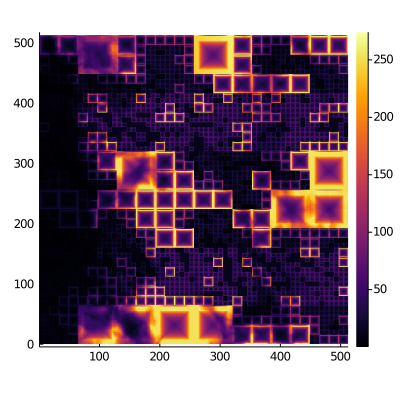

In [112]:
relarr = demoarr ./ maximum(demoarr, dims=2)
r2 = zeros(512, 512)
for i in CartesianIndices(relarr)
  r2[i] = (abs(decompressed[i] - gauss5[i])) * relarr[i]
end

heatmap(r2, size=(400, 400), aspect_ratio=:equal)

In [113]:
typeof(r2)

Array{Float64,2}

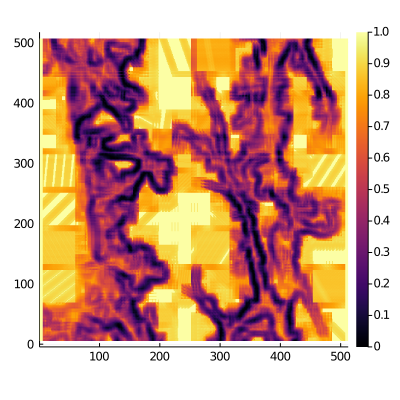

In [114]:
r2 = 1 .- (decon ./ maximum(decon, dims=2))
heatmap(r2, size=(400, 400), aspect_ratio=:equal)

In [115]:
combarr = zeros(512, 512)
relblur = imfilter(relarr, Kernel.gaussian(7))
for i in CartesianIndices(relarr)
  if relarr2[i] < relblur[i]
    combarr[i] = relarr2[i]
  else
    combarr[i] = relblur[i]
  end
end

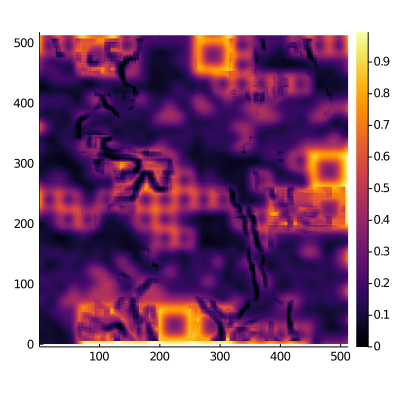

In [116]:
heatmap(combarr, size=(400, 400), aspect_ratio=:equal)

In [117]:
post = zeros(512, 512)
for i in CartesianIndices(gray)
  value = r2[i]
  anti = 1-value
  post[i] = (value * gauss5[i]) + (anti * arr[i])
end

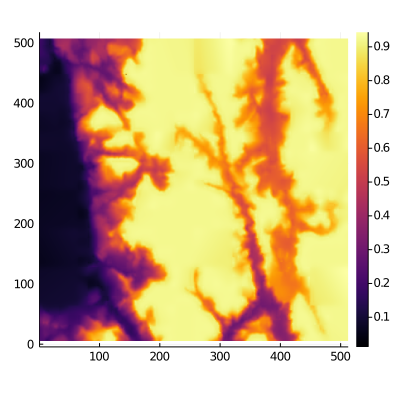

In [118]:
heatmap(post, size=(400, 400), aspect_ratio=:equal)

In [ ]:
gauss5

UndefVarError: [91mUndefVarError: gauss5 not defined[39m